# Grid sag

#### Demonstrates the use of the `grid sag` surface in PAOS


First let's create a grid sag defined by Zernike polynomials on an elliptical aperture.


In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from paos import WFO
from paos.core.run import push_results
from paos.core.plot import simple_plot
from paos.core.parseConfig import parse_config
from paos.core.raytrace import raytrace
from paos.core.run import run

from skimage.transform import rescale

Define beam and propagation parameters


In [2]:
beam_diameter = 1.1
semimaj = beam_diameter / 2
semimin = beam_diameter / 2 / 1.1 * 0.73
grid_size = 1024
zoom = 4
wavelength = 0.55
xdec = ydec = 0.0

lens_fl = 1.0
dz = 1.0

Create a wavefront with a known SFE


In [3]:
retval1 = {}

wfo = WFO(beam_diameter, 1.0e-6 * wavelength, grid_size, zoom)
wfo.aperture(
    xc=xdec,
    yc=ydec,
    hx=semimaj,
    hy=semimin,
    shape="elliptical",
)
wfo.make_stop()

index = np.arange(0, 6)
Z = np.array(
    [
        0,
        10,
        0,
        -30.0,
        20.0,
        0.0,
    ]
)
Z *= 1.0e-9

ordering = "noll"
normalize = True
radius = 0.55

wfe = wfo.zernikes(index, Z, ordering, normalize, radius)

retval1[0] = push_results(wfo)
retval1[0]["aperture"] = None
retval1[0]["ABCDt"] = lambda: None

wfo_shape = wfo._wfo.shape
wfo_dx = wfo.dx
wfo_dy = wfo.dy

wfo.lens(lens_fl=lens_fl)
wfo.propagate(dz=dz)

retval1[1] = push_results(wfo)
retval1[1]["aperture"] = None
retval1[1]["ABCDt"] = lambda: None

Change the SFE by translating it and changing its sizes in x and y


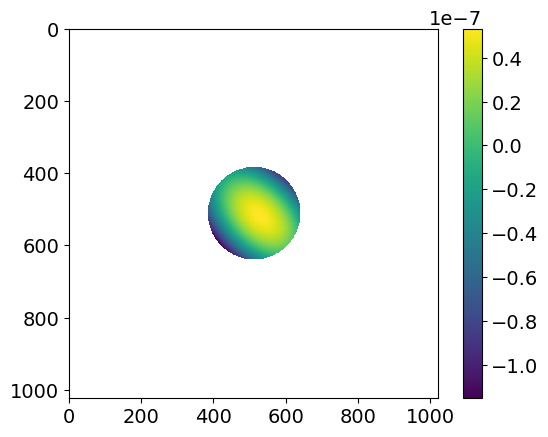

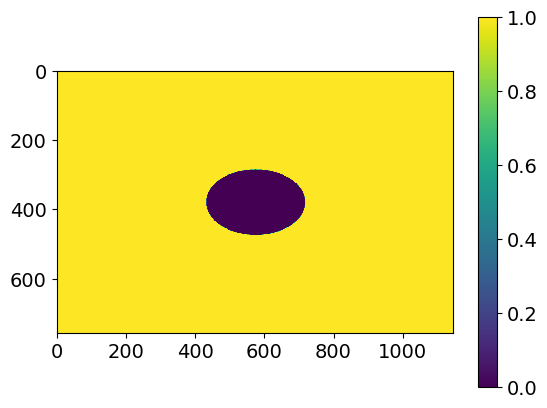

Sum of wfe:  1.9025694787001765e-06
Sum of wfe after mask:  3.9501582313044445e-06


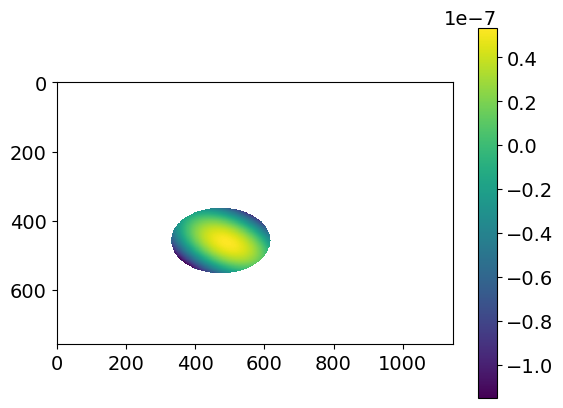

(757, 1147)


In [4]:
# change the WFE sampling when saving
scale_x = 1.11977
scale_y = 0.73901

plt.figure()
plt.imshow(wfe, interpolation="none")
plt.colorbar()
plt.show()

mask = rescale(
    wfe.mask.astype(float),
    scale=(scale_y, scale_x),
    anti_aliasing=(
        scale_x < 1.0 or scale_y < 1.0
    ),  # anti_aliasing is required for downsampling
    order=3,
)

plt.figure()
plt.imshow(mask, interpolation="none")
plt.colorbar()
plt.show()

mask = mask > 0.5

wfe = rescale(
    wfe,
    scale=(scale_y, scale_x),
    anti_aliasing=(
        scale_x < 1.0 or scale_y < 1.0
    ),  # anti_aliasing is required for downsampling
    order=3,
)

wfe1 = wfe.copy()
print("Sum of wfe: ", np.sum(wfe1))

wfe = np.ma.MaskedArray(wfe, mask=mask)
print("Sum of wfe after mask: ", np.sum(wfe))

# shift the WFE by n pixels on both axes
shift = (-101, 79)  # (yshift, xshift)
# shift = (0, 0)  # (yshift, xshift)
wfe = np.roll(wfe, shift, axis=(1, 0))


plt.figure()
plt.imshow(wfe, interpolation="none")
plt.colorbar()
plt.show()

out_dict = {
    "data": wfe * 1.0e9,  # .filled(np.nan),
    # data is in nm
    "nx": wfo_shape[1],
    "ny": wfo_shape[0],
    "delx": wfo_dx / scale_x,
    "dely": wfo_dy / scale_y,
    "xdec": shift[1],
    "ydec": shift[0],
}
np.save("sag.npy", out_dict)

print(wfe.shape)

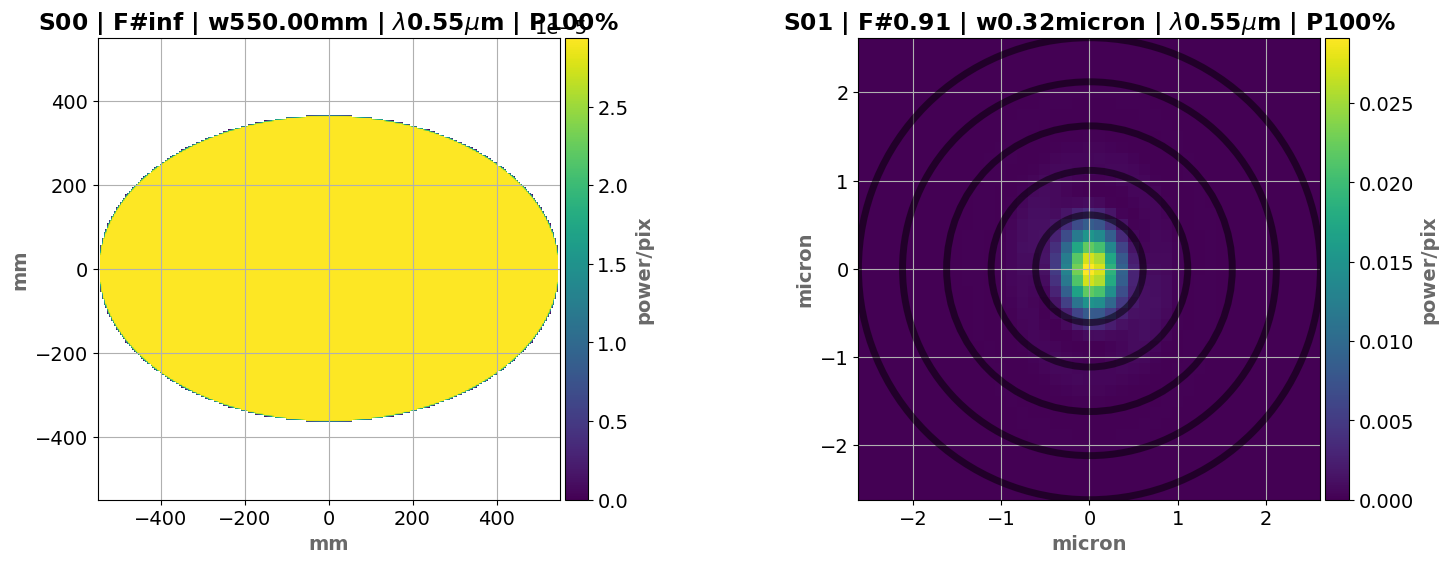

WFE RMS: 37.30 nm
WFE PV: 168.44 nm


In [5]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

simple_plot(fig, ax0, key=0, item=retval1[0], ima_scale="linear")
simple_plot(fig, ax1, key=1, item=retval1[1], ima_scale="linear")
plt.show()

print(f"WFE RMS: {1e9 * np.std(wfe):.2f} nm")
print(f"WFE PV: {1e9 * np.ptp(wfe):.2f} nm")

Now take the saved grid sag and let's see if we can reposition it and resize it to the original values. The check is done at the output PSF.


In [6]:
wfo = WFO(beam_diameter, 1.0e-6 * wavelength, grid_size, zoom)
wfo.aperture(
    xc=xdec,
    yc=ydec,
    hx=semimaj,
    hy=semimin,
    shape="elliptical",
)
wfo.make_stop()

data = np.load("sag.npy", allow_pickle=True).item()
sag, nx, ny, delx, dely, xdec, ydec = (
    data["data"],
    data["nx"],
    data["ny"],
    data["delx"],
    data["dely"],
    data["xdec"],
    data["ydec"],
)
sag *= 1.0e-9
print(sag.mean())

sag = wfo.grid_sag(sag, nx, ny, delx, dely, xdec, ydec)

retval2 = {}
retval2[0] = push_results(wfo)
retval2[0]["aperture"] = None
retval2[0]["ABCDt"] = lambda: None

wfo.lens(lens_fl=lens_fl)
wfo.propagate(dz=dz)

retval2[1] = push_results(wfo)
retval2[1]["aperture"] = None
retval2[1]["ABCDt"] = lambda: None

9.27332495552371e-11


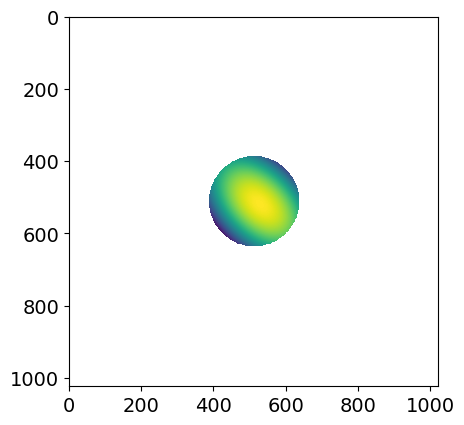

In [7]:
plt.figure()
plt.imshow(sag)
plt.show()

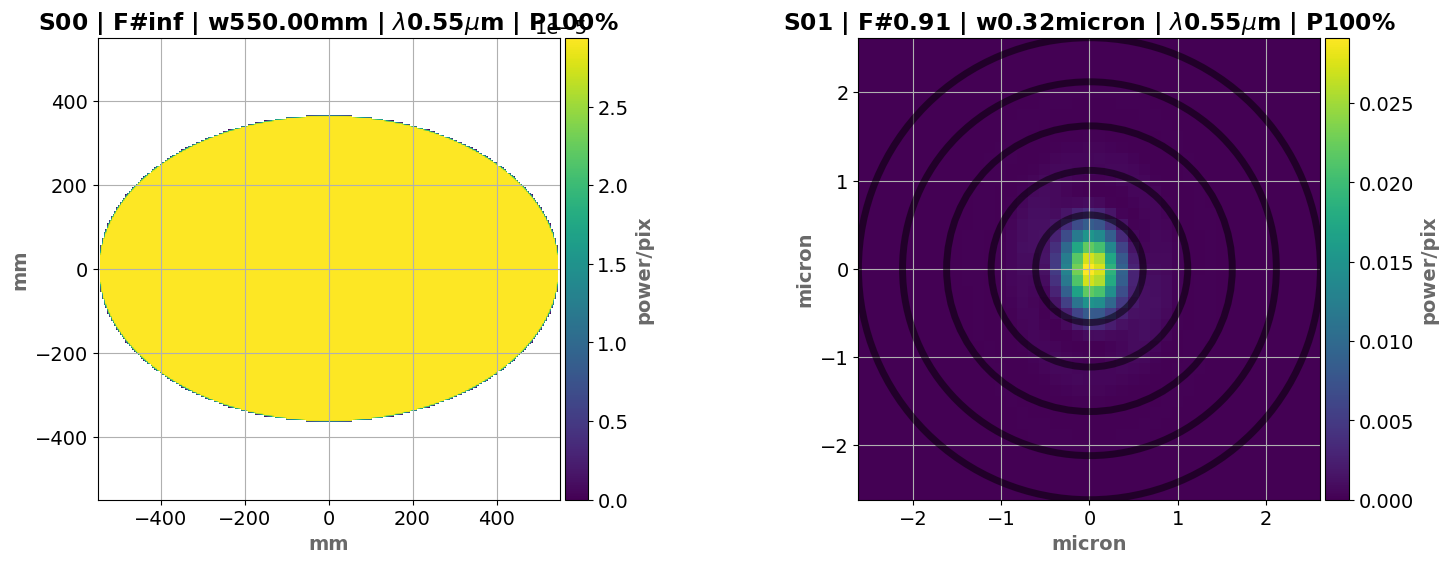

WFE RMS: 37.26 nm
WFE PV: 168.44 nm


In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

simple_plot(fig, ax0, key=0, item=retval2[0], ima_scale="linear")
simple_plot(fig, ax1, key=1, item=retval2[1], ima_scale="linear")
plt.show()

print(f"WFE RMS: {1e9 * np.std(sag):.2f} nm")
print(f"WFE PV: {1e9 * np.ptp(sag):.2f} nm")

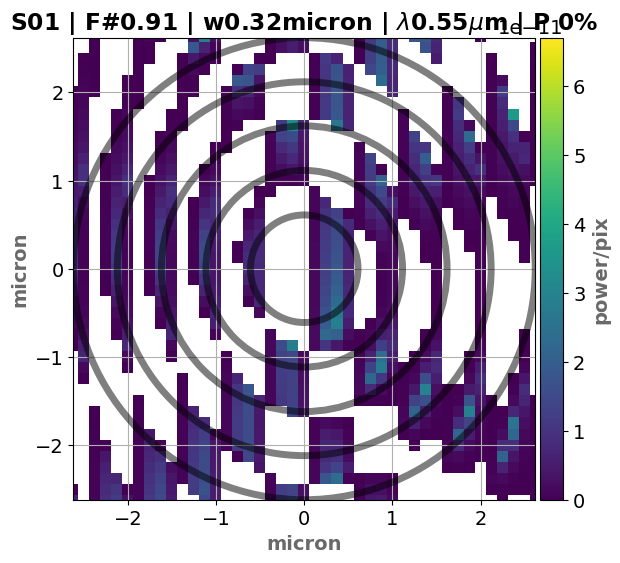

In [9]:
retval_diff = deepcopy(retval2)

amp1 = retval1[1]["amplitude"]
amp2 = retval2[1]["amplitude"]
retval_diff[1]["amplitude"] = amp1 - amp2

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
simple_plot(fig, ax0, key=1, item=retval_diff[1], ima_scale="linear")
plt.show()

Now use the run function directly in the paos run call


In [10]:
OpticalPrescription = 'test_Grid_Sag.ini'
OpticalPrescriptionFile = os.path.join('../lens data', OpticalPrescription)
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config(OpticalPrescriptionFile)
retval3 = run(pup_diameter, 1.0e-6 * wavelengths[0], parameters['grid_size'], parameters['zoom'], fields[0], opt_chains[0])

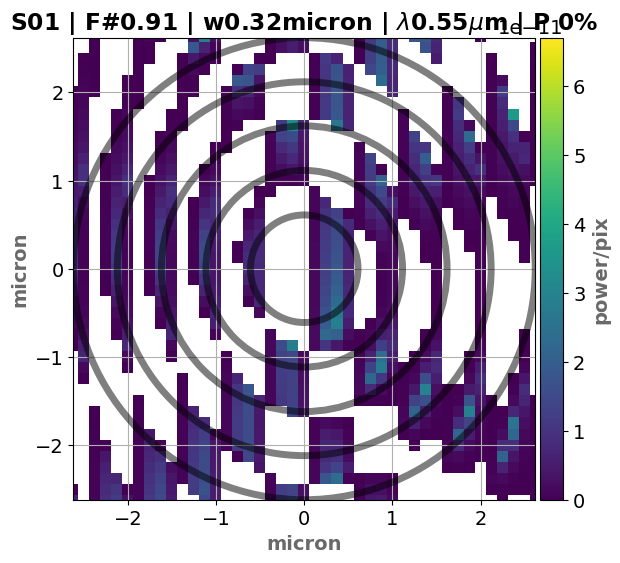

In [11]:
retval_diff = deepcopy(retval1)

amp1 = retval1[1]["amplitude"]
amp3 = retval3[5]["amplitude"]
retval_diff[1]["amplitude"] = amp1 - amp3

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
simple_plot(fig, ax0, key=1, item=retval_diff[1], ima_scale="linear")
plt.show()

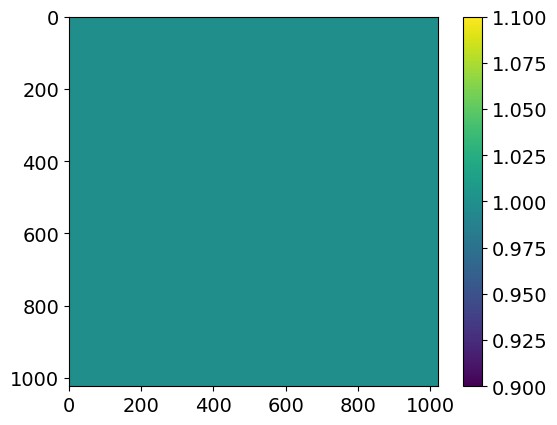

In [12]:
plt.imshow((amp1 - amp2)/(amp1 - amp3))
plt.colorbar()